
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [608]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [609]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,3099,152,172
125769,3099,152,174
125770,3099,167,180
125771,3099,172,178


In [610]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [611]:
ALPHA = 1/2 #S -> E
BETA = 0.8 #E -> I 
GAMMA = 1/30 #I -> R 5

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

print(1/GAMMA)

30.0


# Simulation

In [612]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initisaltion od Status Matrix, where everyone is susceptible
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(3100, 242)


In [613]:
NUMOFPATIENTZERO = 4
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [614]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(list) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].append(node_j)
    edgesDictionaryWRTTime[time][node_j].append(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'list'>, {58: [63], 63: [58, 66], 59: [64], 64: [59], 66: [63], 85: [190, 214], 190: [85], 214: [85, 191], 102: [115], 115: [102], 191: [199, 214], 199: [191]})


In [615]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

In [616]:
for t in range(tMax):
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED
    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

[ 47 117 152 154 157 163 172 176 192]


In [617]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    #print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
print(listPopulations.head())
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
     1  2  3  4
0  238  4  0  0
1  238  3  1  0
2  238  2  2  0
3  237  3  2  0
4  237  1  4  0


Text(0.5, 0, 'Period (in Days)')

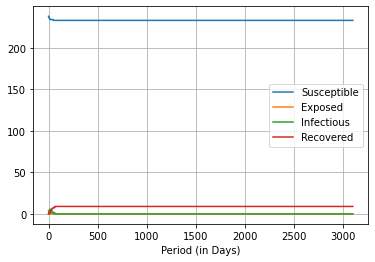

In [618]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot()
plt.legend()
plt.grid()
plt.xlabel("Period (in Days)")

No handles with labels found to put in legend.


Text(0.5, 0, 'Period (in Days)')

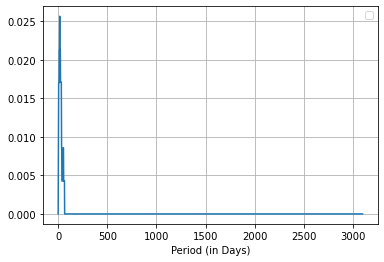

In [619]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()
plt.xlabel("Period (in Days)")

In [620]:
## A function that 
def endOfEpidemic(dfListPopulations):
    endDay = 0
    for row in dfListPopulations.values:
        if row[EXPOSED-1] !=0 or row[INFECTIOUS-1] != 0:
            endDay += 1
        else:
            break
    if endDay == listPopulations.shape[0]:
        return -1
    else:
        return endDay

print("End of Epidemic : ", endOfEpidemic(listPopulations))

End of Epidemic :  65


## Network Visualation using iGraph Package

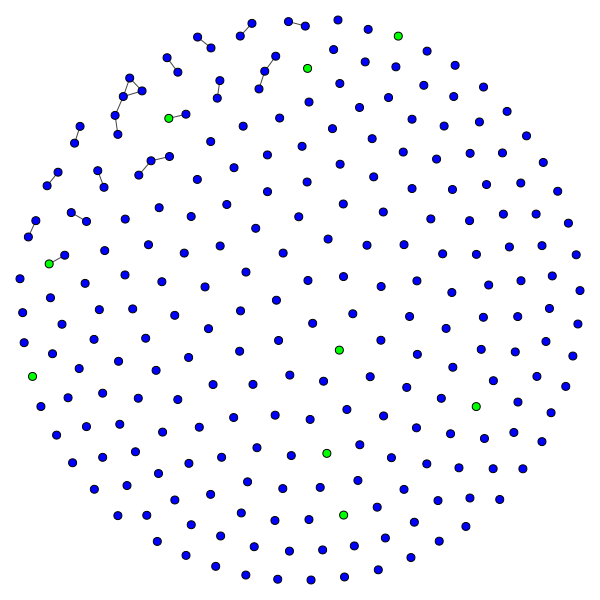

In [621]:
# STATEDICT ={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}


def networkGraphAtTimet(networkData, statusMatrix, time):
    query =  "time=={time}".format(time = time)
    numOfNodes = statusMatrix.shape[1]
    graph = ig.Graph(n=numOfNodes, edges=networkData.query(query)[['node-i','node-j']].values)
    graph.vs["state"] = statusMatrix[time]
    color_dict = {1: "blue", 2: "yellow", 3:"red", 4:"green"}
    graph.vs["color"] = [color_dict[state] for state in graph.vs["state"]]
    return graph

ig.plot(networkGraphAtTimet(networkData, statusMatrix, 82), vertex_size=8)